## Landlab Final Project

In [2]:
# Landlab modules
from landlab import RasterModelGrid
from landlab.components import DepressionFinderAndRouter, FlowAccumulator, LinearDiffuser, NormalFault, StreamPowerEroder

# Other modules
import imageio
from matplotlib import colors
from matplotlib import pyplot as plt
import numpy as np
import os
import pygmt
import rasterio
import re
import xarray as xr

### Helper functions

In [3]:
# Create custom colormap
custom_colors = np.vstack((plt.cm.Blues(np.linspace(1, 0.4, 256)), plt.cm.Greens(np.linspace(0.3, 0.8, 256))))
height_cmap = colors.LinearSegmentedColormap.from_list('height_cmap', custom_colors)

def plot_helper(surf, mg, prop, fault_coords, index, time_now, use_2d, use_3d):
        if use_2d:
            print(f'\rplotting 2D {index} running...', end = '')

            show_terrain_2D(mg.at_node['topographic__elevation'].reshape(surf.shape)[::-1],
                            title = f'{round(time_now)} yAP',
                            cont = True)
            plt.savefig(f'result\\2D-{round(time_now):08d}.png')

            plt.plot(fault_coords.T[0],
                    fault_coords.T[1],
                    c = 'black',
                    ls = 'dashed',
                    lw = 0.5,
                    marker = '.')
            plt.savefig(f'result\\lined\\2D-Lined-{round(time_now):08d}.png')
            plt.close()

            show_terrain_2D(mg.at_node['topographic__elevation'].reshape(surf.shape),
                    cmap = 'Greys_r',
                    title = f'{round(time_now)} yAP',
                    cont = True)
            mask = (mg.at_node['depression__depth'] > 0) | (mg.at_node['drainage_area'] >= 5e4)
            plt.imshow(np.where(mask.reshape(surf.shape), 1, np.nan)[::-1], cmap = 'brg', interpolation = 'none')
            plt.savefig(f'result\\drainage\\2D-Drainage-{round(time_now):08d}.png')
            plt.close()

        if use_3d:
            print(f'\rplotting 3D {index} running...', end = '')
            show_terrain_3D(mg.at_node['topographic__elevation'].reshape(surf.shape)[::-1],
                            prop['spacing'],
                            title = f'{round(time_now)} yAP',
                            show_fig = False,
                            save_fig = f'result\\3D-{round(time_now):08d}.png')

def show_terrain_2D(x: np.ndarray,
                    cmap: str = 'terrain',
                    title: str = 'DEM',
                    colorbar_label: str = 'Elevation (m)',
                    size: tuple = (12, 8),
                    two_slope: bool = False,
                    cont: bool = False,
                    show_fig: bool = True,
                    save_fig: str = None):

    fig, ax = plt.subplots()
    fig.set_size_inches(size)
    if two_slope:
        im = ax.imshow(x[::-1],
                   cmap = cmap,
                   norm = colors.TwoSlopeNorm(vcenter = 0))
    else:
        im = ax.imshow(x[::-1],
                    cmap = cmap)
    cb = fig.colorbar(im, ax = ax)
    cb.set_label(colorbar_label)
    ax.set(title = title, xlabel = 'X', ylabel = 'Y')
    plt.gca().invert_yaxis()

    if not cont:
        if show_fig:
            plt.show()

        if save_fig:
            plt.savefig(save_fig)

        plt.close()

def show_terrain_3D(x: np.ndarray,
                    spacing: tuple,
                    cmap: str = 'terrain',
                    perspective: list = [-45, 30],
                    title: str = 'DEM',
                    x_label: str = 'X',
                    y_label: str = 'Y',
                    z_label: str = 'Elevation (m)',
                    size: tuple = (12, 8),
                    colorbar: bool = True,
                    two_slope: bool = False,
                    sea_surface: bool = True,
                    remove_background: bool = True,
                    remove_axis: bool = True,
                    cont: bool = False,
                    show_fig: bool = True,
                    save_fig: str = None):
    
    x_axis, y_axis = np.meshgrid(np.arange(0, x.shape[1] * spacing[1], spacing[1]),
                                 np.arange(0, x.shape[0] * spacing[0], spacing[0]))

    fig, ax = plt.subplots(subplot_kw = {'projection': '3d'})
    fig.set_size_inches(size)
    if two_slope:
        sf = ax.plot_surface(x_axis,
                             y_axis,
                             x,
                             cmap = cmap,
                             norm = colors.TwoSlopeNorm(vcenter = 0),
                             lw = 0,
                             antialiased = True)
    else:
        sf = ax.plot_surface(x_axis,
                             y_axis,
                             x,
                             cmap = cmap,
                             lw = 0,
                             antialiased = True)
    ax.set(title = title, xlabel = x_label, ylabel = y_label, zlabel = z_label)
    ax.set_proj_type('persp', focal_length = 0.3)
    ax.view_init(azim = perspective[0], elev = perspective[1])

    if (x.min() <= 0) & sea_surface:
        sea = np.zeros(x.shape)
        sea[x >= 0] = np.nan
        ax.plot_surface(x_axis, y_axis, sea, lw = 0, facecolor = '#AAAAAA99')

    plt.gca().invert_yaxis()

    if colorbar:
        cb = fig.colorbar(sf, ax = ax, shrink = 0.75)
        cb.set_label(z_label)

    if remove_background:
        ax.xaxis.set_pane_color('#FFFFFF00')
        ax.yaxis.set_pane_color('#FFFFFF00')
        ax.zaxis.set_pane_color('#FFFFFF00')
        ax.xaxis._axinfo["grid"]['color'] = (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] = (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] = (1,1,1,0)

    if remove_axis:
        ax.set_axis_off()

    if not cont:
        if show_fig:
            plt.show()

        if save_fig:
            plt.savefig(save_fig)

        plt.close()

def show_terrain_3D_two(x: np.ndarray,
                        spacing: tuple,
                        cmap: str = 'geo',
                        perspective: list = [130, 40],
                        show_fig: bool = True,
                        save_fig: str = None):
    
    # Convert to DataArray
    def to_DataArray(data: np.ndarray,
                     x_start: float,
                     x_increment: float,
                     y_start: float,
                     y_increment: float) -> xr.DataArray:
        
        # Inputs
        x_coords = x_start + np.arange(data.shape[1]) * x_increment
        y_coords = y_start + np.arange(data.shape[0]) * y_increment
        
        # Create DataArray
        da = xr.DataArray(data,
                          coords = {'x': x_coords, 'y': y_coords},
                          dims = ['y', 'x']) 
        return da

    fig = pygmt.Figure()
    fig.grdview(to_DataArray(x, 0, spacing[0], 0, spacing[1]),
                region = [0, x.shape[0] * spacing[0], 0, x.shape[1] * spacing[1]],
                perspective = perspective,
                projection = 'x40c',
                zsize = '1c',
                surftype = 's',
                cmap = cmap,
                plane = '+ggrey')
    fig.colorbar(frame=['a1000', 'x+lElevation', 'y+lm'],
                 perspective = True,
                 position = 'JBC+w4c/0.35c')
    
    if show_fig:
        fig.show()

    if save_fig:
        fig.savefig(save_fig)


### Preview the DEM

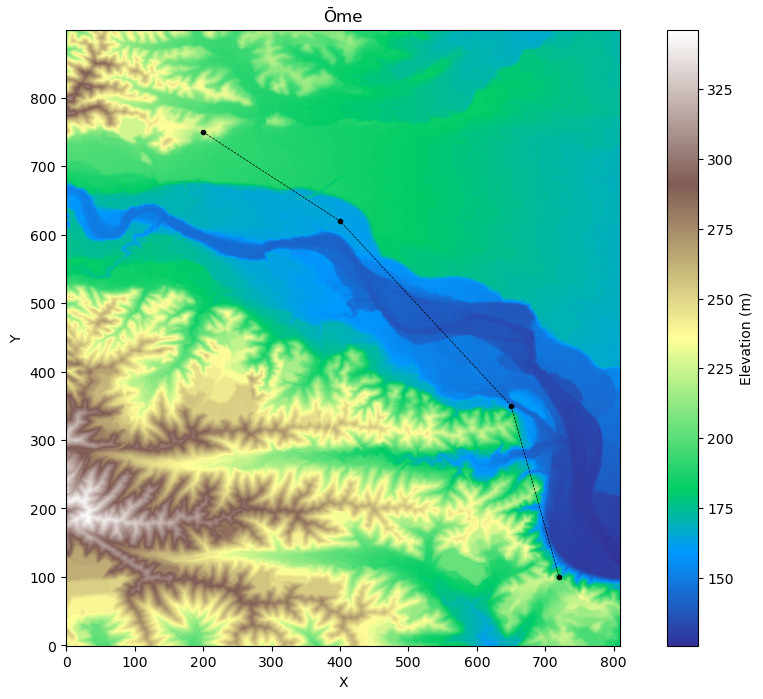

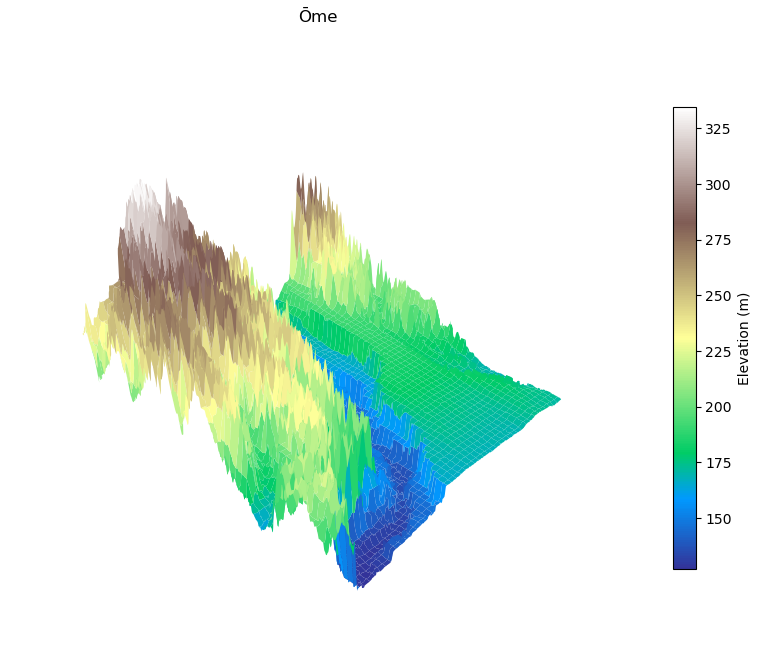

In [ ]:
# Variable assertion
prop = {}
fault_coords = np.array([[ 200,  750],
                         [ 400,  620],
                         [ 650,  350],
                         [ 720,  100]])                                 # Fault linearment in elev's coordinate

with rasterio.open(r'.\src\Ome_5m_810x900_conditioned.tif') as dataset: # EPSG:6668 (JGD2011) is a lat-long based projection
    elev = dataset.read(1).astype(float)
    prop['shape'] = elev.shape
    prop['spacing'] = (5, 5)                                            # 0.2'' x 0.2''

del dataset

show_terrain_2D(elev, title = 'Ōme', cont = True)
plt.plot(fault_coords.T[0],
         fault_coords.T[1],
         c = 'black',
         ls = 'dashed',
         lw = 0.5,
         marker = '.')
plt.show()

show_terrain_3D(elev,
                prop['spacing'],
                cmap = 'terrain',
                title = 'Ōme')

### Landlab engagement

In [8]:
# Variable assertion
mg: RasterModelGrid

# Parameters
iteration = 100
total_time = 100000
uplift = 0.001

# Output parameters
plot_2d = True
plot_3d = True

delta_t = total_time / iteration
fault_landlab_coords = fault_coords.T.copy()
# fault_landlab_coords[1] = prop['shape'][0] - fault_landlab_coords[1]
fault_landlab_coords = fault_landlab_coords * np.array(prop['spacing']).reshape((2, 1))
time_series = np.arange(0, total_time, delta_t)

In [9]:
# Build RasterModelGrid
mg = RasterModelGrid(prop['shape'],
                     xy_spacing = prop['spacing'])

z_field = mg.add_field('topographic__elevation',
                       np.array(elev)[::-1],
                       units = 'm',
                       clobber = True)

print('RasterModelGrid built!')

df = DepressionFinderAndRouter(mg)

fr = FlowAccumulator(mg)

ld = LinearDiffuser(mg,
                    linear_diffusivity = 0.04,
                    deposit = False)

nf_list: list[NormalFault] = []

for i in range(fault_landlab_coords.shape[1] - 1):
    nf_list.append(NormalFault(mg,
                               fault_throw_rate_through_time = {'time': [0], 'rate': [0.001]},
                               fault_dip_angle = 90,
                               fault_trace = {'x1': fault_landlab_coords.T[i, 0],
                                              'y1': fault_landlab_coords.T[i, 1],
                                              'x2': fault_landlab_coords.T[i + 1, 0],
                                              'y2': fault_landlab_coords.T[i + 1, 1]},))

sp = StreamPowerEroder(mg,
                       K_sp = 0.0001,
                       m_sp = 0.5,
                       n_sp = 1,
                       threshold_sp = 0.0)

if not os.path.exists('result'):
    os.makedirs('result')
    print('result folder created!')

if not os.path.exists('result\\lined'):
    os.makedirs('result\\lined')

if not os.path.exists('result\\drainage'):
    os.makedirs('result\\drainage')

plot_helper(elev, mg, prop, fault_coords, i, 0, plot_2d, plot_3d)

for i, current_time in enumerate(time_series):

    for j, nf in enumerate(nf_list):
        print(f'\rnf {i}-{j} running...', end = '')
        nf.run_one_step(delta_t)

    z_field += delta_t * uplift

    print(f'\rld {i} running...', end = '')
    ld.run_one_step(delta_t)

    print(f'\rfr {i} running...', end = '')
    fr.run_one_step()

    print(f'\rdf {i} running...', end = '')
    df.map_depressions()

    print(f'\rsp {i} running...', end = '')
    sp.run_one_step(delta_t)

    plot_helper(elev, mg, prop, fault_coords, i, current_time + delta_t, plot_2d, plot_3d)

RasterModelGrid built!
plotting 3D 99 running...

### Making GIF

In [19]:
def create_gif_from_folder(folder_path, regex, output_filename, fps = 10):
    images = []

    for file_path in [f for f in os.listdir(folder_path) if re.match(regex, f)]:
        images.append(imageio.imread(os.path.join(folder_path, file_path)))
    
    imageio.mimsave(output_filename, images, fps = fps, loop = 0)

create_gif_from_folder('result', r'2D-\d+\.png', 'result\\2D-Simulation.gif')
create_gif_from_folder('result', r'3D-\d+\.png', 'result\\3D-Simulation.gif')
create_gif_from_folder('result\\drainage', r'2D-Drainage-\d+\.png', 'result\\2D-Drainage-Simulation.gif')
create_gif_from_folder('result\\lined', r'2D-Lined-\d+\.png', 'result\\2D-Lined-Simulation.gif')

C:\Users\Daniel\AppData\Local\Temp\ipykernel_24728\816392180.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(folder_path, file_path)))


### Abandoned Idea

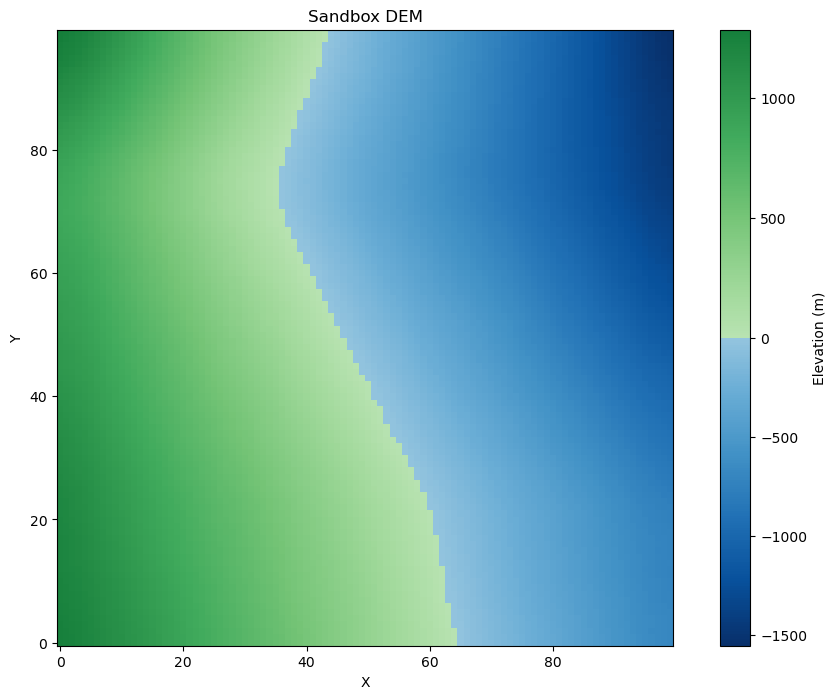

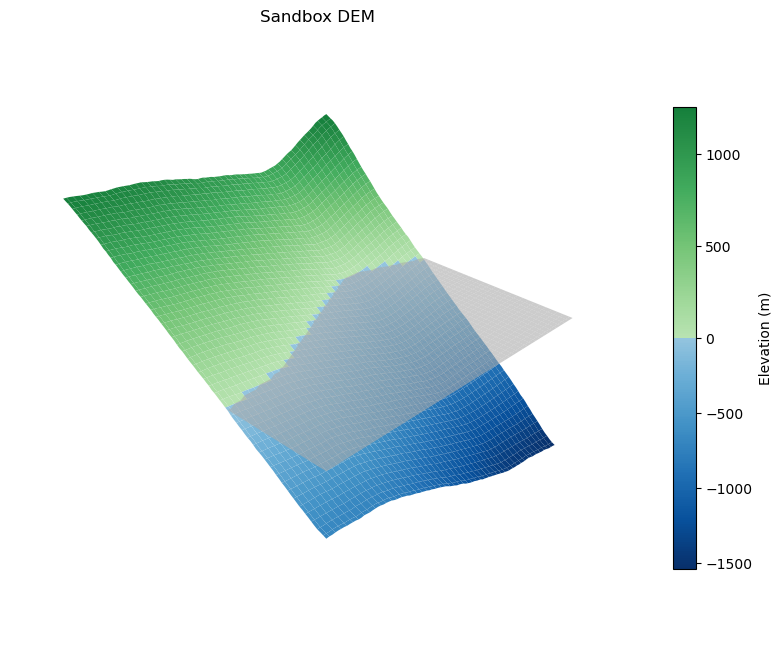

In [7]:
import scipy.signal as signal

# Variable Assertian
elev: np.ndarray
prop = {
        'shape': (100, 100),
        'spacing': (0.0002, 0.0002) # 0.0002 degree is about 20m on Equator
       }

# Sandbox baking
def create_sandbox(high_mean: float,
                   high_std: float,
                   low_mean: float,
                   low_std: float,
                   random_displacement: float,
                   shape: tuple,
                   strip_count: int,
                   seed: int) -> np.ndarray:
    # Inputs
    height = shape[0]
    width  = shape[1]
    rngA = np.random.default_rng(seed)
    rngB = np.random.default_rng(seed + 1)
    rngC = np.random.default_rng(seed + 2)

    # Create terrain surface
    surf = np.full(shape, np.nan)

    # Assign strips
    high_ends = rngA.normal(high_mean, high_std, strip_count)
    low_ends  = rngB.normal( low_mean,  low_std, strip_count)
    for i, idx in enumerate(np.linspace(0, height, strip_count, dtype = int)[:-1]):
        surf[idx] = np.linspace(high_ends[i], low_ends[i], width)

    # Interpolate strips
    valid_rows = np.where(~np.isnan(surf[:, 0]))[0] 
    for i in range(height):
        surf[:, i] = np.interp(np.arange(width), valid_rows, surf[valid_rows, i])

    # Add random variations
    surf += rngC.normal(0, random_displacement, shape)

    # Smooth the terrain
    surf = signal.convolve2d(np.pad(surf, pad_width = 5, mode = 'edge'), np.ones((11, 11)) / 121, mode = 'valid')

    return surf

elev = create_sandbox(high_mean = 1300,
                      high_std = 200,
                      low_mean = -1000,
                      low_std = 300,
                      random_displacement = 40,
                      shape = prop['shape'],
                      strip_count = 5,
                      seed = 36197) + create_sandbox(
                      high_mean = -500,
                      high_std = 40,
                      low_mean = -100,
                      low_std = 15,
                      random_displacement = 10,
                      shape = prop['shape'],
                      strip_count = 5,
                      seed = 3952).T

# Preview
show_terrain_2D(elev,
                cmap = height_cmap,
                title = 'Sandbox DEM',
                two_slope = True)
show_terrain_3D(elev, prop['spacing'],
                cmap = height_cmap,
                title = 'Sandbox DEM',
                two_slope = True)

# Write TIFF
# with rasterio.open('src\\sandbox.tif',
#                    mode = 'w',
#                    driver = 'GTiff',
#                    height = elev.shape[0],
#                    width = elev.shape[1],
#                    count = 1,
#                    dtype = rasterio.float32,
#                    crs = 'EPSG:4326',
#                    transform = rasterio.transform.from_origin(0, 0 + elev.shape[1] * prop['spacing'][1], prop['spacing'][0], prop['spacing'][1])) as dataset:
#     dataset.write(elev, 1)

In [ ]:
# Variable Assertian
dataset: rasterio.DatasetReader
dem_property: dict = {}
elevation_grd: np.ndarray

# Helper Methods
def fill_nan(x: npt.NDArray, verbose: bool = False) -> npt.NDArray:
    '''
    Fill NaN values in the DEM using the mean value of surrounding neighbors.

    Parameters
    --------
    x: NDArray
        The 2D numpy array consisting DEM data.

    verbose: bool
        Whether to print the iteration status during the operation.

    Returns
    --------
    y: NDArray
        The numpy array with NaN values replaced by estimated heights.
    '''
    if not isinstance(x, np.ndarray):
        raise TypeError('The x must be a numpy array.')
    
    if x.ndim != 2:
        raise ValueError('The x must be a 2D array.')

    _iter = 1
    _x = x.copy().astype(float)
    _win = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])

    if verbose:
        print('[fill_nan] Start filling NaN...')

    # Check whether any cell contains NaN
    while np.isnan(_x).any():
        _real_neighbor_count = ndimage.convolve(1 - np.isnan(_x).astype(int), _win, mode = 'constant')
        _summation = ndimage.convolve(np.nan_to_num(_x), _win, mode = 'constant')
        _mask = np.isnan(_x) & (_real_neighbor_count > 1)
        with np.errstate(divide = 'ignore', invalid = 'ignore'):
            np.putmask(_x, _mask, _summation / _real_neighbor_count)
        if verbose & (_iter % 2 == 0):
            print(f'[fill_nan] Iteration {_iter} complete')
        _iter += 1

    if verbose:
        print('[fill_nan] Finish filling NaN!')
    
    return _x

def show_grid_2d(x: npt.NDArray,
                 title = 'DEM',
                 cmap = 'terrain',
                 colorbar_label = 'Elevation (m)'):
    '''
    Quickly show the image of a 2D grid.

    Parameters
    --------
    x: NDArray
        The 2D numpy array consisting DEM data.

    title: str
        The title of the plot.

    cmap: str | Colormap
        The name of the color ramp or the Colormap object.

    colorbar_label: str
        The title of the colorbar.
    '''
    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = cmap)
    cb = fig.colorbar(im, ax = ax, shrink = 0.75)
    cb.set_label(colorbar_label)
    ax.set(title = title, xlabel = 'X', ylabel = 'Y')
    plt.show()

# Open file
with rasterio.open(r'.\src\Kitanishi_Tama_Small_Filled.tif') as dataset:   # EPSG:6668 (JGD2011) is a lat-long based projection
    elevation_grd = dataset.read(1)
    dem_property['shape'] = elevation_grd.shape
    dem_property['cell_size'] = (5.05, 6.15)                            # 0.2'' x 0.2'' is approximately equal to 5.0m x 6.1m ~ 5.1m x 6.2m in this area

del dataset

elevation_grd[elevation_grd == -9999] = np.nan  # NaN value = -9999
elevation_grd = fill_nan(elevation_grd, True)   # Fill NaNs
show_grid_2d(elevation_grd, title = 'Sayama Hills')

In [ ]:
kwds: dict

with rasterio.open(r'.\src\Kitanishi_Tama_6668.tif') as f:
    kwds = f.profile
    kwds.update(driver = 'GTiff',
                dtype = rasterio.float32)

    with rasterio.open(r'.\src\Kitanishi_Tama_Fill_Nodata_6668.tif',
                       mode = 'w',
                       **kwds) as g:
        g.write_band(1, elevation_grd.astype(rasterio.float32))

In [ ]:
# Variable Assertion
mg: RasterModelGrid

# Build RasterModelGrid
mg = RasterModelGrid(dem_property['shape'],
                     xy_spacing = dem_property['cell_size'])

z = mg.add_field('topographic__elevation', elevation_grd[::-1], units = 'm', clobber = True)
mg.imshow('topographic__elevation', cmap = 'terrain')

In [ ]:
# Assign the Tachigawa Fault
fault_coords = np.array([[3250, 2650],
                         [2800, 2100],
                         [1900, 1100],
                         [1100,  500]]) # Fault linearment in elevation_grid's coordinate

fault_landlab_coords = fault_coords.T.copy()
fault_landlab_coords[1] = dem_property['shape'][0] - fault_landlab_coords[1]
fault_landlab_coords = fault_landlab_coords * np.array(dem_property['cell_size']).reshape((2, 1))

# Plot the map
fig, ax = plt.subplots()
ax.plot(fault_coords.T[0], fault_coords.T[1], 'black')
im = ax.imshow(elevation_grd, cmap = 'terrain')
cb = fig.colorbar(im, ax = ax, shrink = 0.75)
cb.set_label('Elevation (m)')
ax.set(title = 'Tachigawa Fault', xlabel = 'X', ylabel = 'Y')
plt.show()

del ax, cb, im, fig

In [ ]:
deltaT = 10000

df = DepressionFinderAndRouter(mg)
fr = FlowAccumulator(mg)
ld = LinearDiffuser(mg,
                    linear_diffusivity = 0.05,
                    deposit = False)
sp = StreamPowerEroder(mg,
                       K_sp = 0.05,
                       threshold_sp = 0)

for i in range(5):
    ld.run_one_step(deltaT)
    fr.run_one_step()
    # df.map_depressions()
    sp.run_one_step(deltaT)
    show_grid_2d(mg.at_node['topographic__elevation'].reshape(dem_property['shape'])[::-1], title = 'Sayama')